In [6]:
import pandas as pd
import os
import sys

module_path = os.path.abspath(os.path.join("..", "src"))
if module_path not in sys.path:
    sys.path.append(module_path)
    
tickers = pd.read_csv("../data/processed/starting_portfolio.csv")['asset'].to_list()
weights = pd.read_csv("../data/processed/starting_portfolio.csv").set_index('asset')

In [7]:
# Commission fee based on Webull, which is known for low commission fees:
# https://www.webull.com.sg/pricing
# Regular and Extended Hours (04:00 - 20:00 EST)
# 0.025%*Total Trade Amount (Min. USD 0.50)

def commission(order_size, price):
    return max(0.5, abs(order_size) * price * 0.00025)

In [8]:
import yfinance as yf
import tqdm
import pickle as pkl

start_date = "2025-02-01"
end_date = "2025-04-01" # Last day is exclusive

portfolio = {}
for asset in tqdm.tqdm(tickers):
    portfolio[asset] = {
        "data": yf.Ticker(asset).history(start=start_date, end=end_date, actions=False),
    }
    
portfolio


100%|██████████| 12/12 [00:03<00:00,  3.96it/s]


{'CZR': {'data':                                 Open       High        Low      Close   Volume
  Date                                                                          
  2025-02-03 00:00:00-05:00  34.874001  35.790001  34.455002  35.529999  3160200
  2025-02-04 00:00:00-05:00  35.700001  36.180000  35.400002  36.130001  2692600
  2025-02-05 00:00:00-05:00  36.270000  36.410000  35.700001  36.310001  1968200
  2025-02-06 00:00:00-05:00  36.619999  37.130001  36.029999  36.400002  3304700
  2025-02-07 00:00:00-05:00  36.632000  36.700001  35.485001  35.720001  4092000
  2025-02-10 00:00:00-05:00  35.790001  35.849998  34.709999  35.570000  5450500
  2025-02-11 00:00:00-05:00  35.150002  36.150002  35.150002  35.490002  4820000
  2025-02-12 00:00:00-05:00  35.209999  35.723999  34.619999  35.599998  3592300
  2025-02-13 00:00:00-05:00  37.310001  38.900002  37.180000  38.869999  8685500
  2025-02-14 00:00:00-05:00  39.389999  40.000000  39.020000  39.759998  3592900
  2025-02-18 

In [9]:
from backtesting import Strategy
import xgboost as xgb
import ta
import pandas as pd

'''
Note: This model needs 1 month of data to predict the next day's change.
'''

class XGBFactory:
    @staticmethod
    def get(path_to_model, buy_threshold, close_threshold):
        class XGBCustom(XGB):
            def init(self):
                super().init(
                    path_to_model=path_to_model,
                    buy_threshold=buy_threshold,
                    close_threshold=close_threshold
                )
        return XGBCustom
    

def add_features(prices):
    indicators = ta.add_all_ta_features(prices, open="Open", high="High", low="Low", close="Close", volume="Volume", fillna=True)
    indicators['ema2'] = indicators['Close'].ewm(span=2, adjust=False).mean()
    indicators['ema3'] = indicators['Close'].ewm(span=3, adjust=False).mean()
    indicators['ema4'] = indicators['Close'].ewm(span=4, adjust=False).mean()
    indicators['ema5'] = indicators['Close'].ewm(span=5, adjust=False).mean()
    indicators['ema6'] = indicators['Close'].ewm(span=6, adjust=False).mean()
    indicators['ema7'] = indicators['Close'].ewm(span=7, adjust=False).mean()
    indicators['ema10'] = indicators['Close'].ewm(span=10, adjust=False).mean()
    indicators['ema20'] = indicators['Close'].ewm(span=20, adjust=False).mean()
    return indicators.copy()


class XGB(Strategy):
    def init(self, path_to_model, buy_threshold, close_threshold):
        self.model = xgb.Booster()
        self.model.load_model(path_to_model)
        self.buy_threshold = buy_threshold
        self.close_threshold = close_threshold
        
    def next(self):
        if len(self.data) < 28:
            return
        
        df = pd.DataFrame({
            "Open": self.data.Open.s,
            "High": self.data.High.s,
            "Low": self.data.Low.s,
            "Close": self.data.Close.s,
            "Volume": self.data.Volume.s
        })
        
        indicators = add_features(df).iloc[-1:]
        y_pred = self.model.predict(xgb.DMatrix(indicators))[0]
        
        if y_pred > self.buy_threshold:
            self.buy()
        elif y_pred < self.close_threshold:
            self.position.close()

In [36]:
from backtesting import Backtest
asset = 'CZR'

import warnings
warnings.filterwarnings("ignore")

data = portfolio[asset]["data"]
data.index = data.index.values.astype("datetime64[D]")
bt = Backtest(
    data, XGBFactory.get(f"../data/processed/xgb/{asset}.json", -1.5, -1.5), 
    cash=1000000, commission=commission, finalize_trades=True
)
run_stats = bt.run().to_dict()
stats = {'asset': asset, '_strategy': 'Unknown'}
stats.update(run_stats)

bt.plot()

GridPlot(id='p5920', ...)

In [11]:
stats['Return (Ann.) [%]']

8.339273374395862

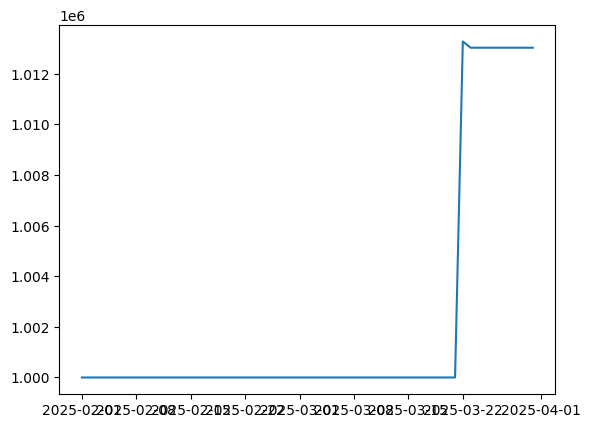

In [12]:
#plot stats['_equity_curve']

import matplotlib.pyplot as plt
plt.plot(stats['_equity_curve']['Equity'])
plt.show()


In [13]:
stats['_equity_curve'][stats['_equity_curve']['Equity'] > 1.000000e+06]


,Equity,DrawdownPct,DrawdownDuration
2025-03-22,1.013278e+06,0.000000,NaT
2025-03-23,1.013031e+06,0.000244,NaT
2025-03-24,1.013031e+06,0.000244,NaT
2025-03-25,1.013031e+06,0.000244,NaT
2025-03-26,1.013031e+06,0.000244,NaT
2025-03-27,1.013031e+06,0.000244,NaT
2025-03-28,1.013031e+06,0.000244,NaT
2025-03-29,1.013031e+06,0.000244,NaT
2025-03-30,1.013031e+06,0.000244,NaT
2025-03-31,1.013031e+06,0.000244,9 days


In [14]:
stats['_trades']


,Size,EntryBar,ExitBar,EntryPrice,ExitPrice,SL,TP,PnL,ReturnPct,EntryTime,ExitTime,Duration,Tag
0,50879,49,50,19.154354,19.420124,None,None,13522.109718,0.013875,2025-03-22,2025-03-23,1 days,None


In [18]:
all_stats = {}
for asset in tickers:
    import warnings
    warnings.filterwarnings("ignore")

    data = portfolio[asset]["data"]
    data.index = data.index.values.astype("datetime64[D]")
    bt = Backtest(
        data, XGBFactory.get(f"../data/processed/xgb/{asset}.json", -1.5, -1.5), 
        cash=1e6 * weights.loc[asset, 'weight'], commission=commission, finalize_trades=True
    )
    run_stats = bt.run().to_dict()
    stats = {'asset': asset, '_strategy': 'Unknown'}
    stats.update(run_stats)

    all_stats[asset] = stats


In [20]:
sum(stats['Equity Final [$]'] for stats in all_stats.values())


999858.4029867908